<a href="https://colab.research.google.com/github/slightperturbation/ml_examples/blob/master/ML_Examples_Binary_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Image Classifier

Binary classification is a little different from multi-class. It uses a single sigmoid instead of a softmax layer for output, and needs to specify a different loss function and metric.

This example is based on the Google/Udacity course's example of distinguishing horses and humans.

In [ ]:
import tensorflow as tf
import os
import zipfile

# Input

This example downloads and unzips data files into /tmp using colab.

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip
  
local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

# Directory with our training horse pictures
validation_horse_dir = os.path.join('/tmp/validation-horse-or-human/horses')

# Directory with our training human pictures
validation_human_dir = os.path.join('/tmp/validation-horse-or-human/humans')

--2020-08-24 03:23:58--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  62.1MB/s    in 2.3s    

2020-08-24 03:24:00 (62.1 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2020-08-24 03:24:02--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 

The ImageDataGenerator streams from the directory and augments the data with a variety of transformations.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/tmp/validation-horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


# Model Definition

Take an RGB image directly into a convolutional layer.

Note the use of a single sigmoid neuron as the output layer since there are only two classes possible. (Zero output means confident horse, an output of one means confident human.) 

In [ ]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation=tf.nn.relu,
                           input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation=tf.nn.relu),

    # One sigmoid output: zero means 'horses' and one means 'humans'
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# Loss Function

`binary_crossentropy` matches the single sigmoidal output for this binary classification task.

# Training

Using `RMSProp` for gradient descent.

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

In model.fit, the "steps" are passes through a batch. So if the batch size is 128 for training, the `steps_per_epoch=8` means 1024 samples will be used in 8 gradient descent updates.

Likewise, `validation_steps=8` means at the end of each epoch, 8 passes over validation batches (set at 32 samples above) will be used to compute the validation metrics. For this reason, it's not a bad idea to make sure that every sample is hit once in the valdiation, e.g., `validation_steps = validation_samples // validation_batch_size`. (In this case, batch = 32, samples = 256 so 8 steps makes sense.)

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,
      epochs=100,
      verbose=1,
      validation_data=validation_generator,
      validation_steps=8)

Epoch 1/100
8/8 [==============================] - 16s 2s/step - loss: 0.6893 - accuracy: 0.5484 - val_loss: 0.6692 - val_accuracy: 0.5000
Epoch 2/100
8/8 [==============================] - 18s 2s/step - loss: 0.6642 - accuracy: 0.5818 - val_loss: 0.6752 - val_accuracy: 0.5000
Epoch 3/100
8/8 [==============================] - 18s 2s/step - loss: 0.6246 - accuracy: 0.6830 - val_loss: 0.6460 - val_accuracy: 0.5000
Epoch 4/100
8/8 [==============================] - 18s 2s/step - loss: 0.6144 - accuracy: 0.6596 - val_loss: 0.5877 - val_accuracy: 0.6367
Epoch 5/100
8/8 [==============================] - 18s 2s/step - loss: 0.5869 - accuracy: 0.6986 - val_loss: 0.6153 - val_accuracy: 0.5469
Epoch 6/100
8/8 [==============================] - 18s 2s/step - loss: 0.5397 - accuracy: 0.7475 - val_loss: 0.5840 - val_accuracy: 0.6094
Epoch 7/100
8/8 [==============================] - 21s 3s/step - loss: 0.5886 - accuracy: 0.7019 - val_loss: 0.7131 - val_accuracy: 0.5312
Epoch 8/100
8/8 [==========


# Visualization

Use the recorded history to compare train and validation accuracy to test for overfitting.

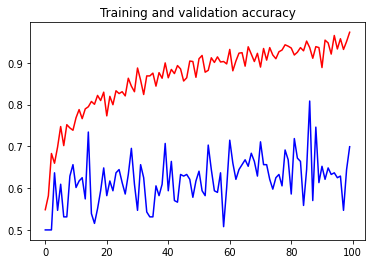

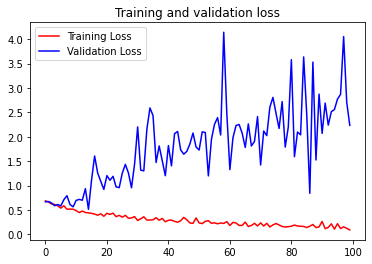

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Results

Expect an accuracy of almost 0.9.